In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{torch.__version__} running on {device}")

2.4.0+cu121 running on cuda


train_data.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Has 10 elements.
train_dl_f_mnist.batch_size = 32
len(next(iter(train_dl_f_mnist))) = 2
next(iter(train_dl_f_mnist))[0].shape = torch.Size([32, 1, 28, 28])
[32, 1, 28, 28] = [MINI_BATCH_SIZE, COLOUR_CHANNEL_COUNT, IMAGE_WIDTH, IMAGE_HEIGHT]
len(train_dl_f_mnist) = 1875, len(test_dl_f_mnist) = 313
Image shape: torch.Size([1, 28, 28])


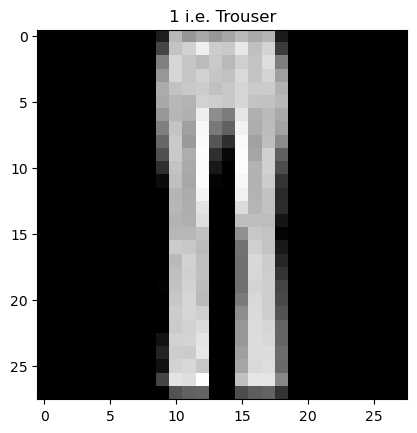

In [2]:
# import my helper files
import individuals as inds
import fashion_mnist_to_dl as fmnist

# GP Run for Image Classification
Your problem needs to fulfill the following criteria.
1. It is an image classification problem.
2. You supply marked training images and marked validation images.

Within those, the run is flexible and adapts itself to your problem.
Now, please describe your images and problem by setting those global variables:

In [3]:
import constants
PC = constants.problem_constants(fmnist.IMAGE_WIDTH, # <-- number of width-pixels
                                fmnist.IMAGE_HEIGHT, # <-- number of height-pixels
                                fmnist.COLOUR_CHANNEL_COUNT, # <-- RGB images would have 3
                                fmnist.CLASSIFICATION_CATEGORIES_COUNT, # <-- the amount of possible categories of which each image shall be marked with one
                                fmnist.MINI_BATCH_SIZE # was chosen in the dataloaders
                                )# this we pass around

testX = torch.randn(PC.channel_count, PC.width, PC.height).to(device)
fmnist.train_dl, fmnist.test_dl

(<torch.utils.data.dataloader.DataLoader at 0x7ff750bfd790>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff7517ff140>)

## GP Code
Now we need to decide the genetic stuff.
1. Initial Population
2. Fitness Measure
3. Selection
4. Genetic Operators
    - Cloning or Crossover
    - Mutation
    
### Hyperparameter-landscape is vast. Here's a list:
- Net architecture
    - kind of layers, number of layers
        - for convolution/pooling: kernel size, stride, padding, (dilation) **[implemented]**
    - number of neurons per layer
    - activation function for each layer
- cost function
    - base term (e.g. square cost, log-likelihood, cross-entropy, ect.)
    - toppings 
        - regularization of weights (L2, L1, dropout, etc.)
- weights and biases optimization technique (= optimizer)
    - SGD (= stochastic gradient descent)
    - Hessian technique, i.e. momentum-based descent
    - PyTorch's various other (e.g. *Adam* optimizer)
- learning parameters
    - η ... learning rate
        - constant, or epoch-dependent, or accuracy-dependent, or a mix
    - \# of epochs
        - constant, or early stopping
    - (`mini_batch_size` - this one might be canonical)

## The Individuals' Class
- I think I want to define a class for one `nn.Sequential` 2d-block
    - All possible instances should be concatenable with all possible instances
    - The first gene is not allowed to choose `~.in_channels`, it must match `COLOUR_CHANNEL_COUNT`
    - Every gene but the first is not allowed to choose `~.in_channels`, it must match `~.out_channels` of the prior gene
- We construct an `NN_individual` from an `NN_dna` class that contains all the genetic information necessary
- We add `device` and fitness dictionaries as member variables

In [4]:
print(inds.Gene_2d_block(PC.width, 3).toString())

out_channels = 3 <-- (28 x 28)
conv_2d (kernel, stride, padding) =	(3, 1, 1) --> (28 x 28)
max_pool_2d (kernel, stride, padding) =	(2, 2, 0) --> (14 x 14)


### Fitness Evaluation
We want a population that:
- achieves high (validation/test data) accuracy after training
    - the final accuracy `acc(NN1(t_final))` of an individual `NN1` is used
- trains fast, i.e. takes little CPU time to achieve high accuracy called **Running Accuracy**
    - the individual's accuracy `acc(NN1(t))` is summed over given timestamps `t`, like `Σ_t{acc(NN1(t))}`
    - possibly we want to value early accuracy more, summing `Σ_t{acc(NN1(t))/t}` instead

In [5]:
import evaluation as eval
import torchmetrics
from torchmetrics import functional
import time
import torch.nn.functional as F

We now train the whole population simultaneously, populating the individuals' fitness value parameters:
- `train_losses` ... a dictionary filled with the train loss function results for each batch (independent of how often we test, because it comes for free)
- `test_losses` ... same as above but evaluating on test data instead, and only whenever we choose to test (obviously; this is not free)
- `accs` ... a dictionary with same keys as `test_losses`, filled with the fraction of correct model predictions by total number of predictions
- `acc` ... a single number - the most recent accuracy (defined similarly as `accs`)
- `running_acc` ... a single number - the sum of all known accuracies (i.e. at all times where we tested), divided by the time
    - here, we exclude the first accuracy because the division is very big in that case, and accuracy only depends mainly on weight initialization

### Mutate
Should be guided by randomness, and not too radical.
1. Fix a bound of *radicalities* fixed at 1.
2. Each possible operation of mutation needs to come with a *factor of impact* **λ**
    - e.g. delete/add 2d block: **λ = 5**
    - e.g. learning rate times 1.1: **λ = 0.5**
3. Now we spin the wheels for each call of `mutate_individual`:
    - random radicality **0 < R < 1**
    - random raw likelihood **0 < p < 1** for each possible operation
    - execute an operation iff **λ•p < R** where **λ** and **p** correspond to the operation in question

### GP Run
1. Create a random population of given POP_SIZE
2. `train_and_evaluate_gen` for one epoch
3. choose the half of `NN_individual`s that has the best `running_acc`
4. mutate each chosen NN **twice**
5. continue at *2.* unless you are already at gen FINAL_GEN

In [6]:
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
pd.set_option('display.expand_frame_repr', False)

In [7]:
def return_evolution_df(gens: list[inds.NN_population]):
    inds = sorted([gens[i][j] for i in range(len(gens)) for j in range(len(gens[i]))], key=lambda ind: ind.name) # all individuals of all generations, sorted by name
    rows = []
    for ind in inds:
        rows.append([ind.name, '['+ind.dna.toString()+']', ind.running_acc, ind.acc.item()*100, f"{ind.elapsed_training_time:.2f}s"])
    df = pd.DataFrame(rows, columns=['Name','DNA','running_acc','acc','training time'])#.sort_values(by='running_acc',ascending=False)
    cmap_bad_good = LinearSegmentedColormap.from_list("custom_map", ["darkred", "white", "green"])
    df_styled = df.style.background_gradient(cmap_bad_good).format({'running_acc':"{:.3g}",'acc':"{:.1f}"}).set_properties(**{'text-align': 'left'})

    return df_styled

In [8]:
def pedegree_plot(gens):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Store positions for each individual (to create branches)
    positions = {}  
    branch_lines = []
    colors = {}  # To assign a unique color for each initial individual
    initial_names = [ind.name for ind in gens[0]]  # Get the names of initial individuals

    # Generate a colormap with distinct colors for each initial individual
    color_map = plt.colormaps.get_cmap('tab10')  # Get a colormap with enough unique colors

    for i, name in enumerate(initial_names):
        colors[name] = color_map(i)

    # Plot each generation
    for i, gen in enumerate(gens):
        for ind in gen:
            name = ind.name
            # Find the root ancestor (initial individual) for this individual
            root_name = name.split('.')[0]

            # Determine parent (if exists)
            parent_name = name.rsplit('.', 1)[0] if '.' in name else None

            # Store the current generation and its value for the plot
            x = i  # Generation is the x-axis
            y = ind.acc.cpu()*100  # Value is the y-axis
            
            # Add the individual to the positions dict
            if name not in positions:
                positions[name] = (x, y)

            # If the individual has a parent, create a branch line
            if parent_name and parent_name in positions:
                parent_x, parent_y = positions[parent_name]
                branch_lines.append([(parent_x, parent_y), (x, y), root_name])

            # Plot the individual as a point (using root_name color)
            ax.scatter(x, y, color=colors[root_name])

    # Draw the branch lines
    for branch in branch_lines:
        (x0, y0), (x1, y1), root_name = branch
        ax.plot([x0, x1], [y0, y1], color=colors[root_name])

    # Create a legend for the initial individuals
    handles = [plt.Line2D([0], [0], color=colors[name], lw=2, label=name) for name in initial_names]
    ax.legend(handles=handles, title='Lineage', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set labels
    ax.set_xlabel("Generations")
    ax.set_ylabel("Accuracy [%]")
    ax.set_title("NN Individual Evolution Across Generations")

    # Show the plot
    plt.show()

***** Gen. 2 / 2 *****
*** Commencing epoch 1 / 1 for 4 individuals, one line each. ***


1. NN0.a [(4,7,12,7,13) SGD@λ1μ-1 Hub@δ=.1 | 0.0091] 8.5%: : 563it [00:08, 63.46it/s] 
2. NN0.b [(5,7,12,7,13) SGD@λ1μ-1 Hub@δ=.1 | 0.11] 8.5%: : 563it [00:12, 46.62it/s] 
3. NN1.a [(13,4,8) SGD@λ-1μ0 CE | 0.1] 9.7%: : 563it [00:11, 47.01it/s] 
4. NN1.b [(12,4,8,13) SGD@λ-1μ0 Hub@δ=1 | 0.091] 9.7%: : 563it [00:10, 54.95it/s] 


This took 54.30s.
******* SUMMARY *******


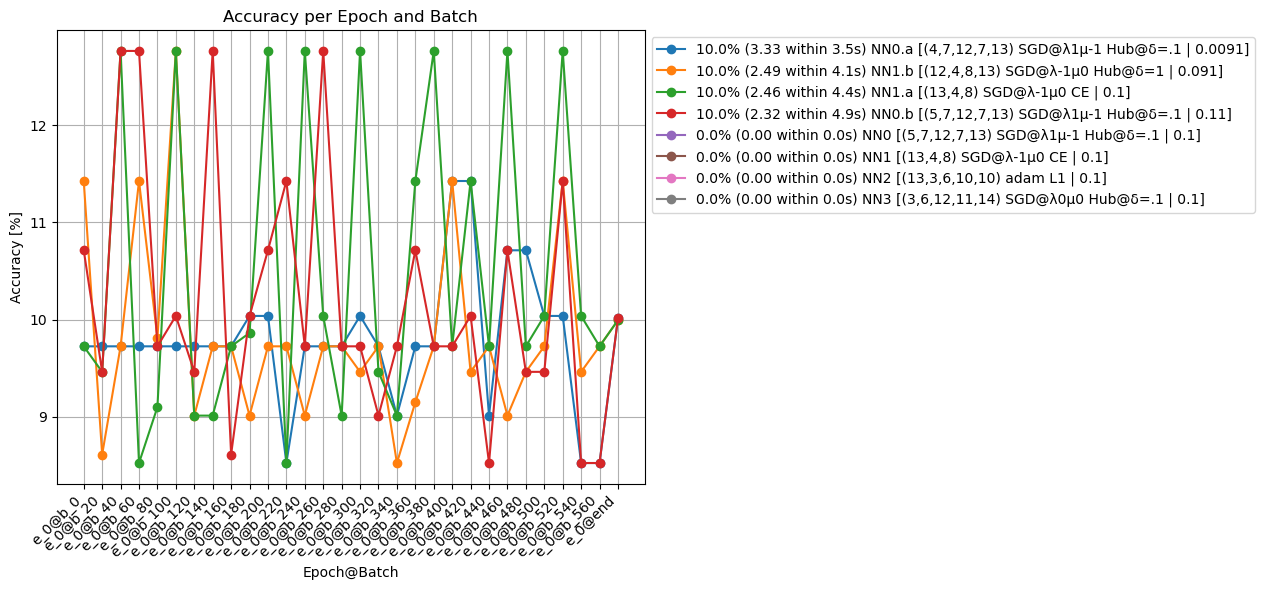

AttributeError: 'int' object has no attribute 'cpu'

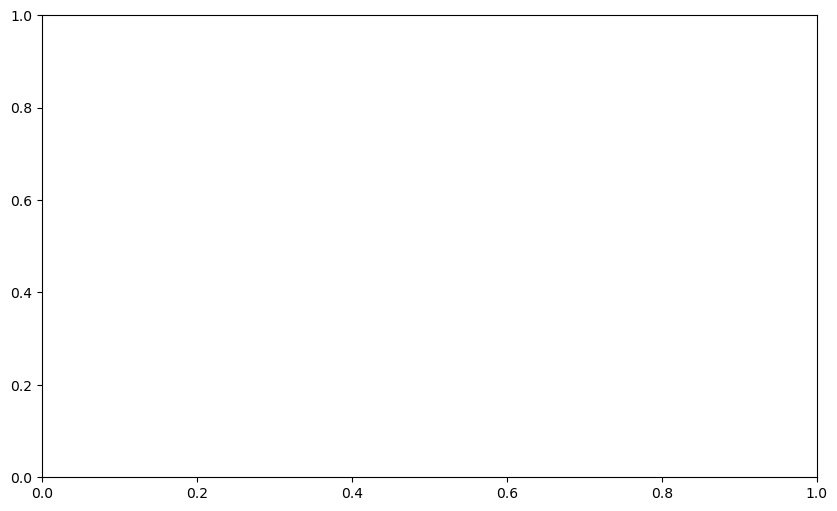

In [9]:
import gp_run as gp


initial_pop = gp.create_random_population(pop_size=4, PC=PC, max_2d_block_count=7, max_kernel_size=11, name_prefix="NN", device=device, print_summary=False)
run = gp.GP_run(PC=PC, initial_pop=initial_pop, train_dl=fmnist.train_dl, test_dl=fmnist.test_dl)
run.resume(for_n_gens=1)
run.pedegree_plot()
run.return_evolution_df()


***** Gen. 4 / 5 *****
*** Commencing epoch 1 / 1 for 4 individuals, one line each. ***


1. NN1.b.b.a [(6) SGD@λ-1μ1 Hub@δ=.1 | 0.0083] 10.9%: : 563it [00:05, 110.19it/s]
2. NN1.b.b.b [(6) SGD@λ-1μ1 Hub@δ=.1 | 0.0091] 10.9%: : 563it [00:05, 101.85it/s]
3. NN1.b.a.a [(4) SGD@λ-1μ1 Hub@δ=.1 | 0.091] 10.9%: : 563it [00:08, 67.99it/s]
4. NN1.b.a.b [(4) SGD@λ-1μ1 Hub@δ=.1 | 0.083] 10.9%: : 563it [00:07, 71.37it/s]


This took 35.56s.
***** Gen. 5 / 5 *****
*** Commencing epoch 1 / 1 for 4 individuals, one line each. ***


1. NN1.b.b.b.a [(6) SGD@λ-1μ1 Hub@δ=.1 | 0.0083] 11.1%: : 563it [00:07, 71.72it/s]
2. NN1.b.b.b.b [(5) SGD@λ-1μ1 Hub@δ=.1 | 0.01] 11.1%: : 563it [00:07, 73.01it/s]
3. NN1.b.b.a.a [(6) SGD@λ-1μ1 Hub@δ=.1 | 0.0075] 11.1%: : 563it [00:07, 72.43it/s]
4. NN1.b.b.a.b [(7) SGD@λ-1μ1 Hub@δ=1 | 0.0075] 11.1%: : 563it [00:08, 69.62it/s]


This took 41.09s.
******* SUMMARY *******


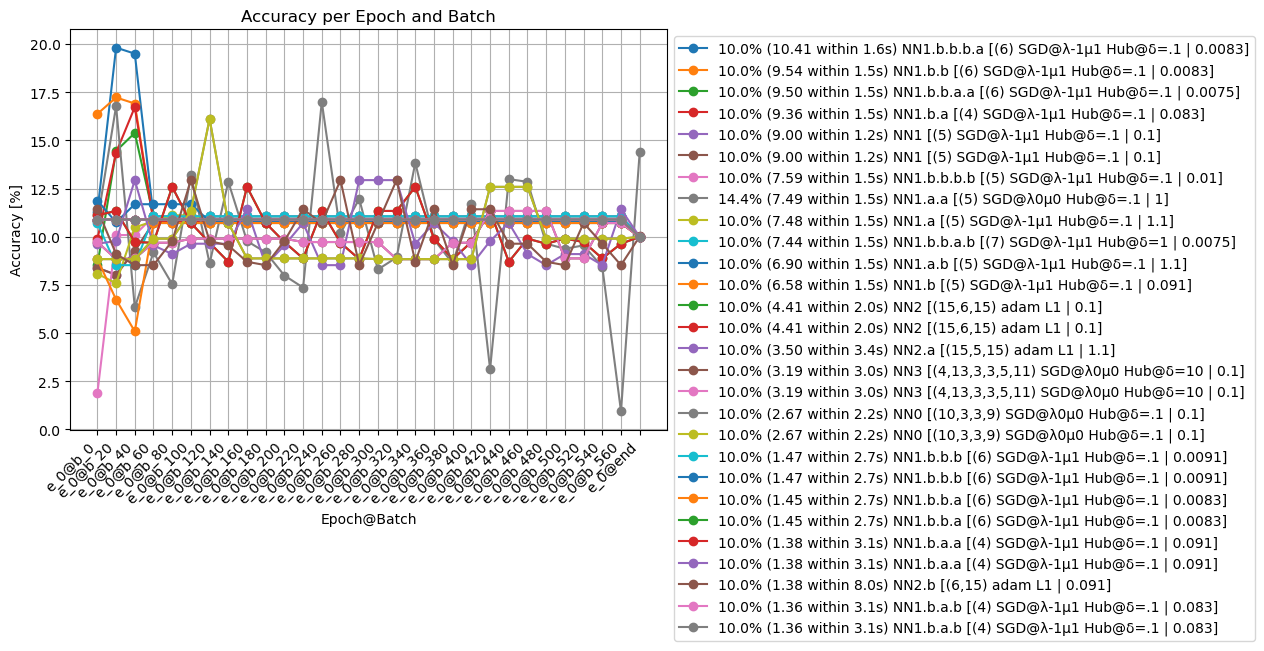

In [10]:
run.resume(for_n_gens=1)

TODO:
- change the mutation for the lr by using a Gauss distribution weighed by the p_raw and radicality
- increase the space of possible mutations / initializations